<a href="https://colab.research.google.com/github/Minh-Do02/IMDB-Movies-Review/blob/main/IMDB_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
lakshmi25npathi_imdb_dataset_of_50k_movie_reviews_path = kagglehub.dataset_download('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')

print('Data source import complete.')


100%|██████████| 25.7M/25.7M [00:00<00:00, 112MB/s]

Extracting files...


Data source import complete.


In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Chargement et Exploration des Données

In [37]:
# 1. Importation des bibliothèques
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')



# 2. Affichage des fichiers dans le répertoire d'entrée pour trouver le bon chemin
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Chargement des données depuis le bon répertoire
#data = pd.read_csv('/kaggle/input/lakshmi25npathi-imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data = pd.read_csv(os.path.join(lakshmi25npathi_imdb_dataset_of_50k_movie_reviews_path, 'IMDB Dataset.csv'))

data['review'] = data['review'].str.lower()

data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


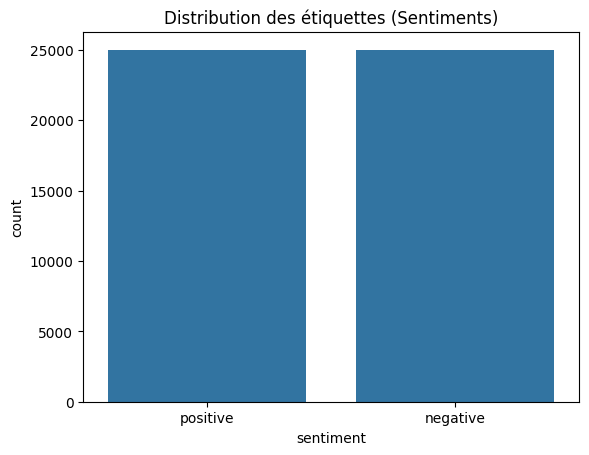

In [38]:
import seaborn as sns
from matplotlib import pyplot as plt

# Visualisation de la répartition des classes
sns.countplot(x="sentiment", data=data)
plt.title("Distribution des étiquettes (Sentiments)")
plt.show()

# Préparation des Données

In [39]:
# Vérification des valeurs manquantes
print(data.isnull().sum())

# Si des valeurs manquantes existent, les supprimer ou les imputer
data = data.dropna()

# Vérification après nettoyage
print(data.isnull().sum())


review       0
sentiment    0
dtype: int64
review       0
sentiment    0
dtype: int64


In [41]:
# Nettoyage et tokenisation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
data['review_clean'] = data['review'].apply(
    lambda x: ' '.join([word for word in word_tokenize(x) if word.isalnum() and word not in stop_words])
)

data.head()

,review,sentiment,review_clean
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...
1,a wonderful little production. <br /><br />the...,positive,wonderful little production br br filming tech...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...
4,"petter mattei's ""love in the time of money"" is...",positive,petter mattei love time money visually stunnin...


### Prépare les séquences et appliquez le padding pour garantir que toutes les séquences ont la même longueur.

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Paramètres pour LSTM
max_words = 5000  # Nombre de mots les plus fréquents
max_len = 100  # Longueur maximale des séquences

# Initialisation du tokenizer Keras
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['review_clean'])  # Utilisation de la colonne 'review_clean'

# Conversion des textes en séquences d'indices
X_seq = tokenizer.texts_to_sequences(data['review_clean'])

# Padding des séquences pour que toutes aient la même longueur
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Séparation des données d'entraînement et de validation (80% entraînement, 20% validation)
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)  # Convertir 'positive'/'negative' en 1/0

X_train_lstm, X_val_lstm, y_train, y_val = train_test_split(X_pad, y, test_size=0.2, random_state=42)
X_train_lstm = np.array(X_train_lstm, dtype=np.int32)
X_val_lstm = np.array(X_val_lstm, dtype=np.int32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)


# Vérification des dimensions après padding
print(f"Forme des données d'entraînement après padding : {X_train_lstm.shape}")
print(f"Forme des données de validation après padding : {X_val_lstm.shape}")


Forme des données d'entraînement après padding : (40000, 100)
Forme des données de validation après padding : (10000, 100)


In [17]:
# génération donnés
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

def augment_text_with_synonyms(text):
    words = word_tokenize(text)
    augmented_text = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Prendre un synonyme aléatoire du mot
            synonym = synonyms[0].lemmas()[0].name()
            augmented_text.append(synonym)
        else:
            augmented_text.append(word)
    return ' '.join(augmented_text)

sample_text = "The movie was really good and I enjoyed it."
augmented_text = augment_text_with_synonyms(sample_text)
print(augmented_text)


The movie Washington truly good and iodine enjoy information_technology .


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Construction du Modèle LSTM


### Le modèle reste essentiellement le même, avec une architecture basée sur des couches Embedding, LSTM, Dense et des techniques de régularisation pour éviter le surapprentissage

In [44]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization


'''
# Reconstruction du modèle
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_shape=(max_len,), mask_zero=True),  # Utilisation explicite de input_shape
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),  # LSTM avec unités
    #Dense(64, activation='relu'),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),  # Régularisation
    Dense(1, activation='sigmoid')  # Sortie binaire
])'''
# Reconstruction du modèle
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_shape=(max_len,), mask_zero=True),  # Utilisation explicite de input_shape
    LSTM(8, dropout=0.2),  # LSTM avec unités
    BatchNormalization(),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    Dropout(0.5),  # Régularisation
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    Dense(1, activation='sigmoid')  # Sortie binaire
])


# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Résumé du modèle
model.summary()




Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 64)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 8)                   │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 325,825 (1.24 MB)

 Trainable params: 325,809 (1.24 MB)

 Non-trainable params: 16 (64.00 B)

In [45]:

#history = model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), epochs=5, batch_size=200)
sample_size = 20000  # Utilisez 20 000 exemples au lieu de 50 000
X_train_sample = X_train_lstm[:sample_size]
y_train_sample = y_train[:sample_size]

from tensorflow.keras.callbacks import EarlyStopping

# Initialisation de l'arrêt anticipé pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

'''
history = model.fit(
    X_train_sample, y_train_sample,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_lstm, y_val),
    callbacks=[early_stopping],
    verbose=1
)
'''
# Entraîner le modèle

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(
    X_train_lstm, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_lstm, y_val),
    callbacks=[early_stopping, reduce_lr],  # Ajout du scheduler de taux d'apprentissage
    verbose=1
)
'''
# données augmentées
X_augmented = tokenizer.texts_to_sequences(data['review_augmented'])
X_augmented_pad = pad_sequences(X_augmented, maxlen=max_len)

# Train-test split avec les données augmentées
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_augmented_pad, y, test_size=0.2, random_state=42)

# Entraînement avec les données augmentées
history = model.fit(
    X_train_aug, y_train_aug,
    epochs=20,
    batch_size=128,
    validation_data=(X_val_aug, y_val_aug),
    callbacks=[early_stopping],
    verbose=1
)'''


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.6885 - loss: 4.7726 - val_accuracy: 0.8731 - val_loss: 0.6374 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.8904 - loss: 0.5178 - val_accuracy: 0.8647 - val_loss: 0.4377 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.9085 - loss: 0.3788 - val_accuracy: 0.8769 - val_loss: 0.3926 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.9209 - loss: 0.3317 - val_accuracy: 0.8753 - val_loss: 0.3850 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.9327 - loss: 0.2943 - val_accuracy: 0.8725 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.9404 - loss: 0.2699 - val_accuracy: 0.8698 - val_loss: 0.4136 - learning_rate: 0.0010
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.9462 - l

"\n# données augmentées\nX_augmented = tokenizer.texts_to_sequences(data['review_augmented'])\nX_augmented_pad = pad_sequences(X_augmented, maxlen=max_len)\n\n# Train-test split avec les données augmentées\nX_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_augmented_pad, y, test_size=0.2, random_state=42)\n\n# Entraînement avec les données augmentées\nhistory = model.fit(\n    X_train_aug, y_train_aug,\n    epochs=20,\n    batch_size=128,\n    validation_data=(X_val_aug, y_val_aug),\n    callbacks=[early_stopping],\n    verbose=1\n)"

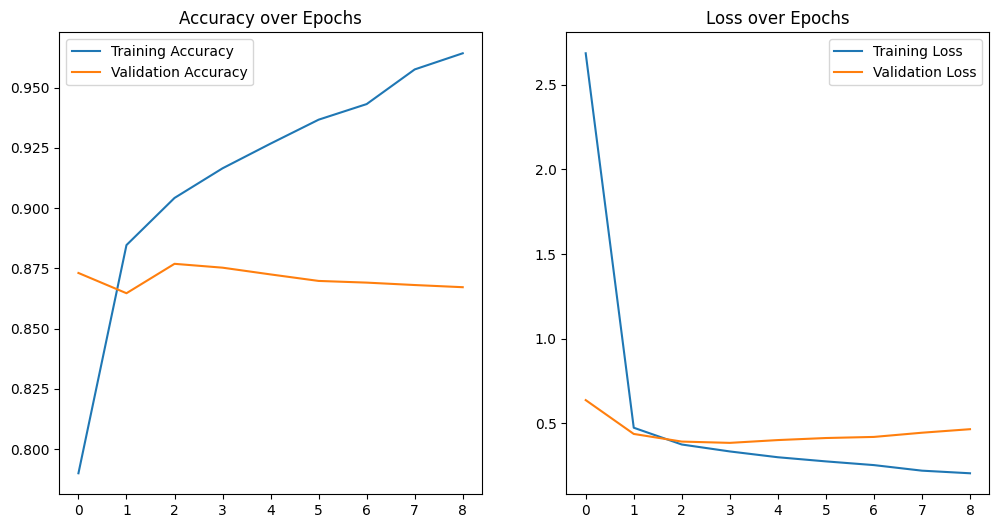

In [46]:
# Plot accuracy/loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [47]:
# Évaluation du modèle LSTM
loss, accuracy = model.evaluate(X_val_lstm, y_val)
print(f"Accuracy: {accuracy*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8720 - loss: 0.3916
Accuracy: 87.53%


In [20]:
# Sauvegarde du modèle
model.save("lstm_model.keras")

# Prédiction

In [22]:
# Charger le modèle sauvegardé
from tensorflow.keras.models import save_model, load_model

model = load_model('lstm_model.keras')


In [23]:
# Faire des prédictions sur les données de validation
val_predictions = model.predict(X_val_lstm)

# Convertir les probabilités en classes
val_predicted_classes = (val_predictions > 0.5).astype(int)


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step


In [24]:
from sklearn.metrics import classification_report

# Afficher le rapport de classification
print(classification_report(y_val, val_predicted_classes))


              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87      4961
         1.0       0.86      0.90      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



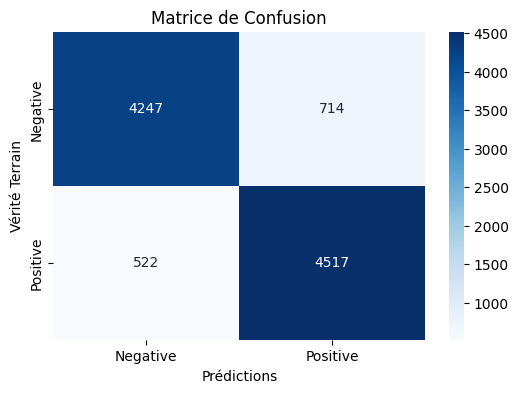

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, val_predicted_classes)

# Visualiser la matrice
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Prédictions')
plt.ylabel('Vérité Terrain')
plt.title('Matrice de Confusion')
plt.show()


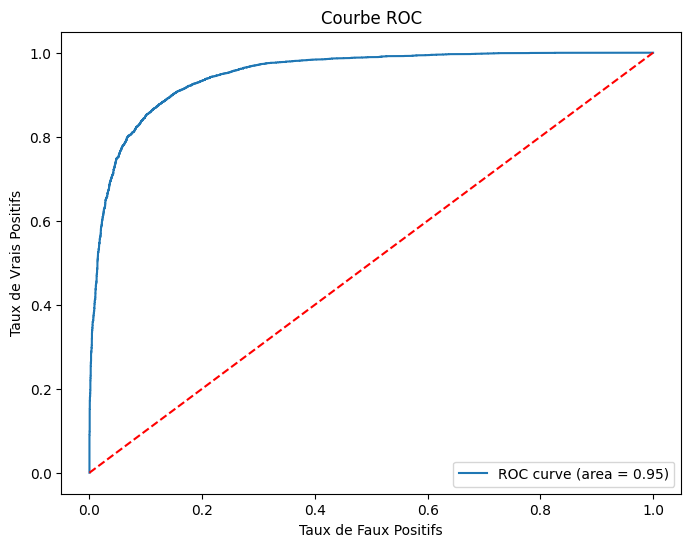

In [27]:
from sklearn.metrics import roc_curve, auc

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_val, val_predictions)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')  # Diagonale pour le hasard
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()
